## Librerías necesarias

In [38]:
import pandas as pd
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap
from  bertopic import BERTopic
from transformers import pipeline
from bertopic.representation import TextGeneration
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import seaborn as sns

In [39]:
df_ar = pd.read_csv("../data/cleaned_data/arabe_limpio.csv", sep="\t", encoding="utf-8")
df_ar.rename(columns={"Texto": "text", "Capítulo": "capitulo", "Versículo": "versiculo"}, inplace=True)
print(df_ar["text"].head())

eng_q = pd.read_csv('../data/cleaned_data/cleaned_english_quran.txt', 
                    sep="|", 
                    names=["capitulo", "verso", "text"],
                    engine="python",
                    quoting=3, # Necesario para evitar problemas con las comillas en el texto en inglés.
                    header=None)

df_en = pd.DataFrame(eng_q)
print(df_en["text"].head())
df_en.head()

0    بسم الله الرحمن الرحيم
1     الحمد لله رب العالمين
2             الرحمن الرحيم
3            مالك يوم الدين
4    اياك نعبد واياك نستعين
Name: text, dtype: object
0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,text
0,1,1.0,in the name of allah the entirely merciful the...
1,1,2.0,all praise is due to allah lord of the worlds
2,1,3.0,the entirely merciful the especially merciful
3,1,4.0,sovereign of the day of recompense
4,1,5.0,it is you we worship and you we ask for help


Cargamos los modelos de fasttext obtenidos en el otro notebook

In [40]:
fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

In [41]:
fasttext_english = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

# Clustering de capítulos con HDBSCAN
Para este nuevo apartado, usaremos el mismo modelo de embeddings usado anteriormente (fasttext) utilizaremos UMAP para la reducción de dimensionalidad. Ya que supuestamente funciona mejor para embeddings que el PCA (usado antes) y usaremos el modelo de clustering HDBSCAN para visualizar los grupos de capítulos más similares en un espacio bidimensional.

En árabe primero:

In [42]:
df_ft = df_ar.copy()
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]
df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: fasttext_arabe.get_sentence_vector(x))
print(df_ft.dtypes)
df_ft.head()

capitulo           float64
versiculo          float64
text                object
arab_embeddings     object
dtype: object


,capitulo,versiculo,text,arab_embeddings
0,1.0,1.0,بسم الله الرحمن الرحيم,"[0.03631257, 0.0074394746, 0.013095561, -0.012..."
1,1.0,2.0,الحمد لله رب العالمين,"[0.0030007623, -0.010423319, -0.053992927, 0.0..."
2,1.0,3.0,الرحمن الرحيم,"[0.0410747, 0.017006857, 0.014440306, 0.001093..."
3,1.0,4.0,مالك يوم الدين,"[0.07585367, -0.012540054, -0.047324788, 0.019..."
4,1.0,5.0,اياك نعبد واياك نستعين,"[0.043237805, -0.02516479, -0.06165533, 0.0213..."


Ahora agrupamos los embeddings por capítulos en matrices y luego hacemos la media para poder obtener el embedding medio. Es algo similar a lo que haria fasttext pero en vez de hacer la media de los vectores de las palabras de una frase la hacemos por capítulos enteros.

In [43]:
embeddings_cap_ar = (
    df_ft.groupby("capitulo")["arab_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_ar.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
print(embeddings_cap_ar.head(5))

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
   capitulo                                    arab_embeddings
0       1.0  [0.041730937, -0.007313849, -0.028332895, 0.00...
1       2.0  [0.035852425, -0.0048943805, -0.028815849, 0.0...
2       3.0  [0.036627408, -0.004995515, -0.027388025, 0.00...
3       4.0  [0.032175925, -0.006694064, -0.025411481, -0.0...
4       5.0  [0.037523985, -0.005679174, -0.029034786, 0.00...


Ahora reducimos la dimensionalidad de los vectores de 300 a 10 dimensiones gracias a UMAP

In [44]:
# Ahora vamos a reducir su dimensionalidad con UMAP
X = np.vstack(embeddings_cap_ar["arab_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_ar = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_ar.fit_transform(X_scaled)

Agrupación con HDBSCAN

In [45]:
hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_ar["cluster"] = labels

Imprimimos los clusters que se han creado y los capítulos que no tienen cluster

In [46]:
for c in sorted(embeddings_cap_ar["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")

Capítulos sin cluster: [6.0, 10.0, 11.0, 25.0, 26.0, 34.0, 49.0, 50.0, 66.0, 76.0, 84.0, 85.0, 95.0, 103.0, 104.0, 105.0, 111.0, 112.0]
Cluster 0: [55.0, 74.0, 75.0, 78.0, 79.0, 80.0, 88.0, 89.0, 91.0, 92.0, 99.0]
Cluster 1: [53.0, 81.0, 87.0, 113.0]
Cluster 2: [1.0, 67.0, 86.0, 97.0, 106.0, 108.0, 114.0]
Cluster 3: [13.0, 14.0, 31.0, 35.0, 42.0, 100.0, 110.0]
Cluster 4: [8.0, 9.0, 47.0, 58.0, 59.0, 63.0, 98.0]
Cluster 5: [2.0, 3.0, 5.0, 60.0, 61.0]
Cluster 6: [71.0, 82.0, 101.0, 109.0]
Cluster 7: [7.0, 15.0, 37.0, 38.0, 40.0, 44.0, 51.0, 54.0, 56.0, 68.0, 77.0, 83.0, 102.0]
Cluster 8: [4.0, 24.0, 33.0, 48.0, 65.0]
Cluster 9: [22.0, 57.0, 62.0, 64.0]
Cluster 10: [16.0, 30.0, 39.0, 45.0]
Cluster 11: [21.0, 23.0, 27.0, 28.0, 29.0, 36.0, 41.0, 43.0, 46.0]
Cluster 12: [32.0, 52.0, 70.0, 107.0]
Cluster 13: [12.0, 19.0, 20.0, 69.0]
Cluster 14: [17.0, 18.0, 72.0, 90.0]
Cluster 15: [73.0, 93.0, 94.0, 96.0]


Mostramos los resultados:

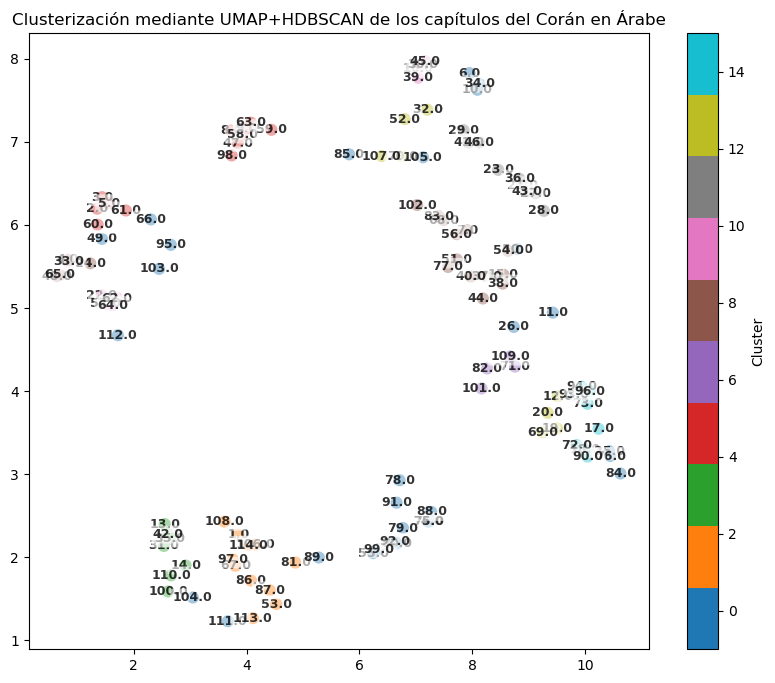

In [47]:
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_ar = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_ar[:,0], X_2D_ar[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_ar["capitulo"]):
    plt.text(
        X_2D_ar[i, 0],
        X_2D_ar[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en Árabe")
plt.colorbar(label="Cluster")
plt.show()

En el caso de la clusterización de capítulos en inglés, lo haremos directamente ya que lo hemos explicado más detenidamente en el ejemplo árabe.

In [48]:
df_en = df_en.dropna(subset=["text"])
df_en = df_en[df_en["text"].str.strip() != ""]
df_en["text"] = df_en["text"].astype(str)
print(df_en["text"].head())
df_en["eng_embeddings"] = df_en["text"].apply(lambda x: fasttext_english.get_sentence_vector(x))
df_en["capitulo"] = pd.to_numeric(df_en["capitulo"], errors="coerce").fillna(0).astype(int)
df_en["verso"] = pd.to_numeric(df_en["verso"], errors="coerce").fillna(0).astype(int)
df_en = df_en[df_en["verso"] != 0]
df_en.head()

0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,text,eng_embeddings
0,1,1,in the name of allah the entirely merciful the...,"[-0.027756814, -0.030271927, -0.0037039993, -0..."
1,1,2,all praise is due to allah lord of the worlds,"[0.0012205791, -0.015658868, 0.001786625, 0.01..."
2,1,3,the entirely merciful the especially merciful,"[-0.060177997, -0.035889216, 0.018935863, -0.0..."
3,1,4,sovereign of the day of recompense,"[0.012451093, -0.007927477, -0.0095781125, 0.0..."
4,1,5,it is you we worship and you we ask for help,"[0.016558215, 0.0019790933, -0.009872921, 0.02..."


Hacemos el mismo proceso que con el arabe

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
Capítulos sin cluster: [23, 25, 36, 38, 53, 55, 66, 72, 73, 79, 87, 89, 91, 93, 95, 104, 106]
Cluster 0: [44, 50, 51, 54, 77, 105]
Cluster 1: [1, 13, 14, 22, 30, 31, 35, 42, 57, 59, 62, 64, 110]
Cluster 2: [52, 82, 83, 102]
Cluster 3: [6, 10, 29, 32, 34, 39, 40, 41, 45, 46, 67]
Cluster 4: [4, 24, 33, 48, 65]
Cluster 5: [2, 3, 5, 8, 9, 16, 47, 49, 58, 60, 61, 63, 98, 107]
Cluster 6: [81, 85, 97, 100, 113, 114]
Cluster 7: [7, 15, 21, 37, 43, 68]
Cluster 8: [17, 18, 71]
Cluster 9: [11, 12, 19, 20, 26, 27, 28, 94, 96, 108, 109]
Cluster 10: [56, 70, 76, 78, 80, 88, 90, 92, 101, 111, 112]
Cluster 11: [69, 74, 75, 84, 86, 99, 103]


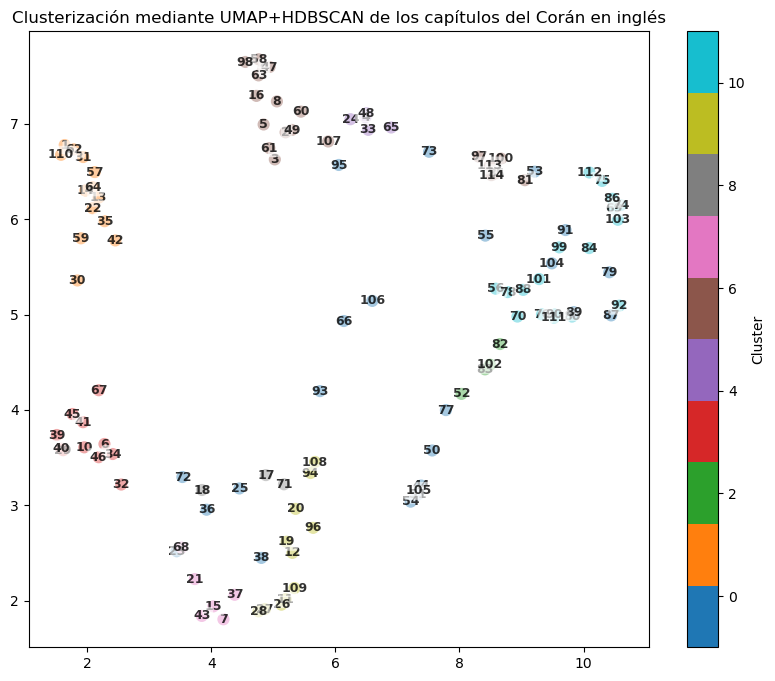

In [49]:
embeddings_cap_eng = (
    df_en.groupby("capitulo")["eng_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_eng.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
X = np.vstack(embeddings_cap_eng["eng_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_eng = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_eng.fit_transform(X_scaled)

hdbscan_eng = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_eng.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_eng["cluster"] = labels

for c in sorted(embeddings_cap_eng["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
        
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_eng = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_eng[:,0], X_2D_eng[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_eng["capitulo"]):
    plt.text(
        X_2D_eng[i, 0],
        X_2D_eng[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en inglés")
plt.colorbar(label="Cluster")
plt.show()

## Comparación de Resultados del Clustering
Después de obtener los resultados, vamos a comparar cuáles capítulos se mantienen en el mismo grupo tanto en inglés como en árabe y cuáles cambian de posición en nuestro espacio bidimensional.

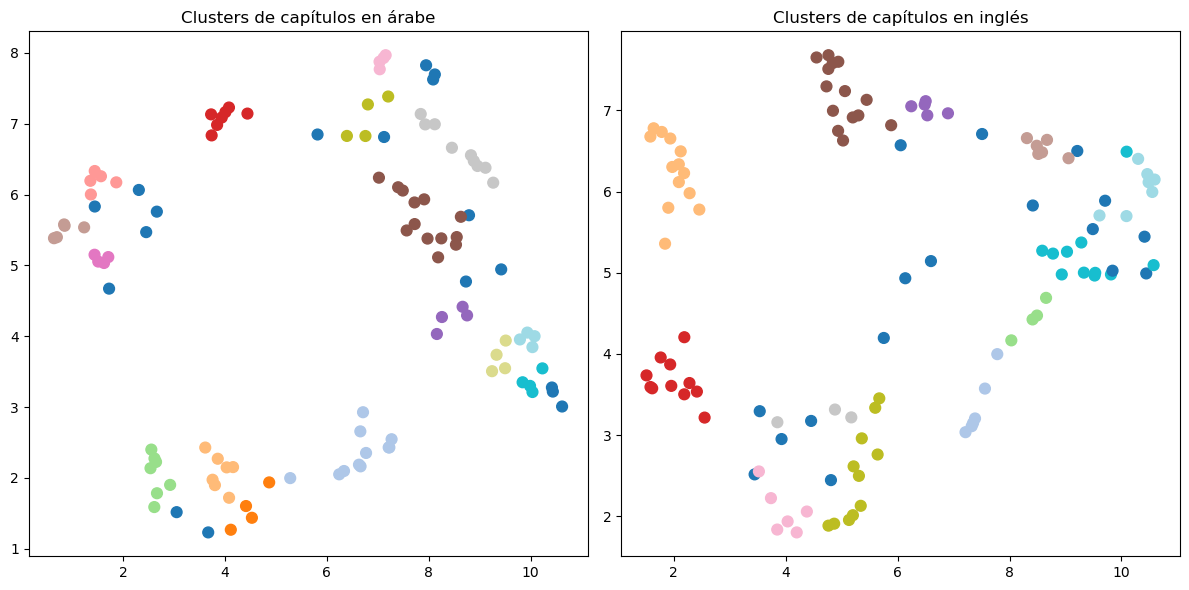

In [50]:
compare_df = embeddings_cap_ar[["capitulo", "cluster"]].merge(embeddings_cap_eng[["capitulo", "cluster"]], on="capitulo", suffixes=("_ar", "_eng"))
# En esta línea creamos una columna binaria para ver qué capítulos cambian o no de cluster respecto al idioma
compare_df["cambio"] = compare_df["cluster_ar"] != compare_df["cluster_eng"] 

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(
    X_2D_ar[:,0], X_2D_ar[:,1],
    c = embeddings_cap_ar["cluster"], cmap="tab20", s=60
)
axes[0].set_title("Clusters de capítulos en árabe")

axes[1].scatter(
    X_2D_eng[:,0], X_2D_eng[:,1],
    c = embeddings_cap_eng["cluster"], cmap="tab20", s=60
)
axes[1].set_title("Clusters de capítulos en inglés")
plt.tight_layout()
plt.show()


En esta comparación lado a lado podemos ver la diferente distribución de clusters, y como podemos ver no hay mucha similitud. Contamos con 15 clusters árabes y 11 ingleses.

Text(120.72222222222221, 0.5, 'Cluster en Árabe (15 Clusters)')

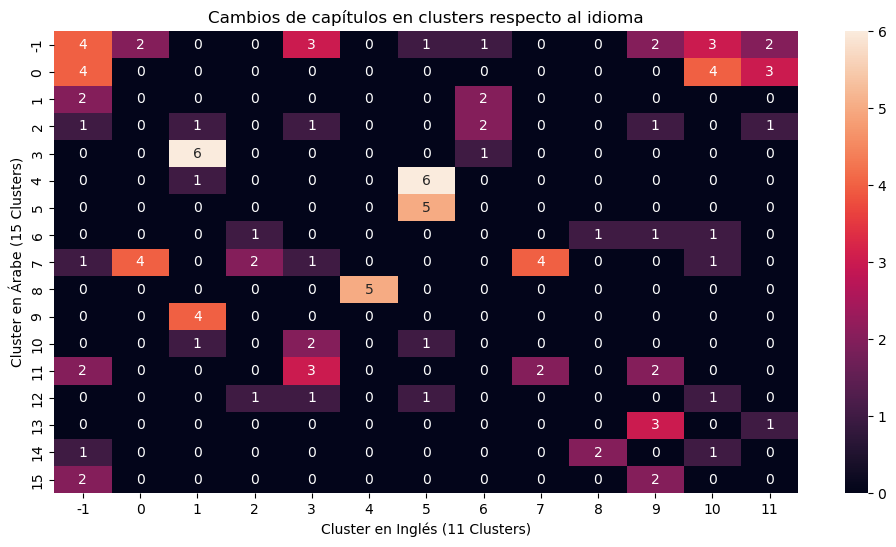

In [51]:
cambios = pd.crosstab(compare_df["cluster_ar"], compare_df["cluster_eng"])
plt.figure(figsize=(12, 6))
sns.heatmap(cambios, annot=True)
plt.title("Cambios de capítulos en clusters respecto al idioma")
plt.xlabel("Cluster en Inglés (11 Clusters)")
plt.ylabel("Cluster en Árabe (15 Clusters)")

Text(0.5, 0.98, 'Plot de los capítulos que han sí y no han cambiado de cluster entre idiomas\nVerde: ha cambiado\nRojo: no ha cambiado')

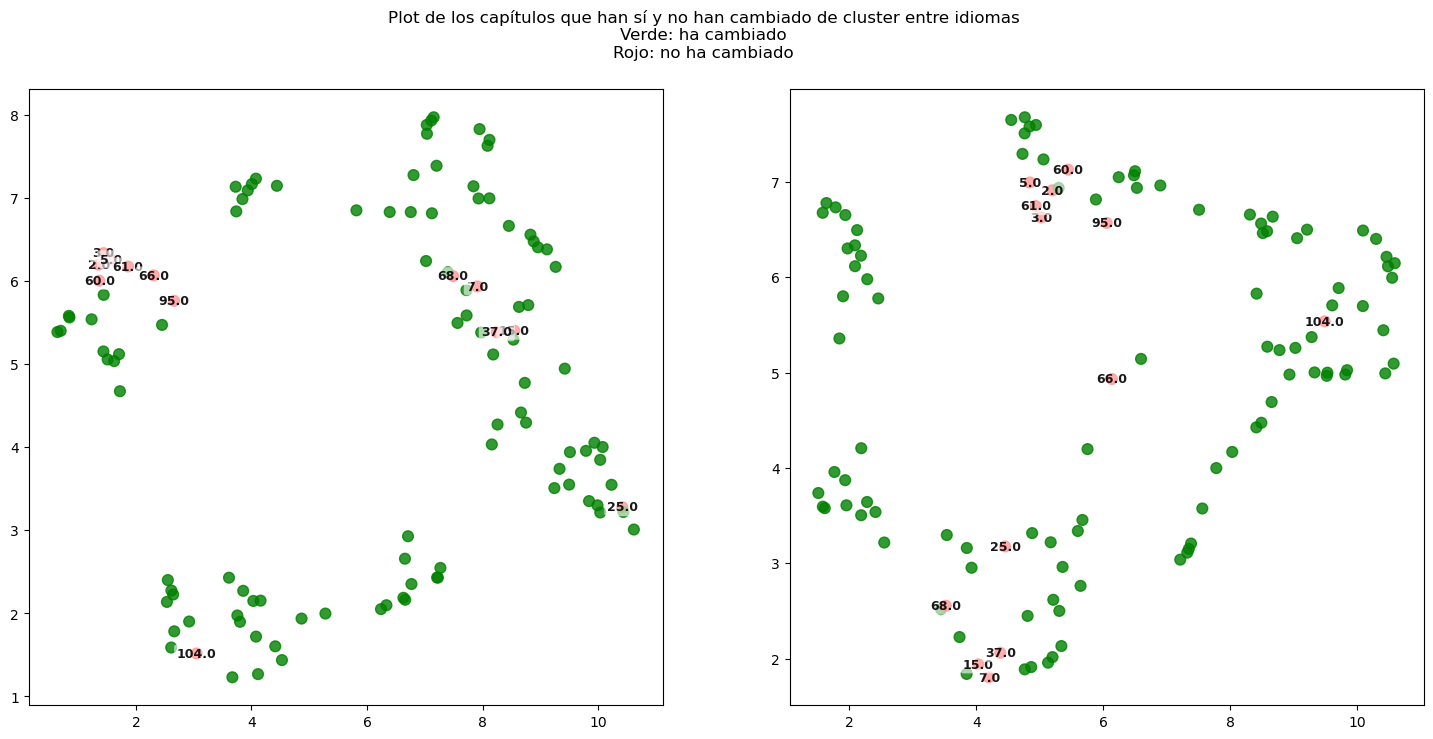

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8)) 

ax = axes[0]
scatter_ar = ax.scatter(
    X_2D_ar[:, 0],
    X_2D_ar[:, 1],
    c=compare_df["cambio"].map({True: "green", False: "red"}),
    s=60,
    alpha=0.8
)

for i, row in compare_df.iterrows():
    if row["cambio"] == False:
        ax.text(
            X_2D_ar[i, 0],
            X_2D_ar[i, 1],
            str(row["capitulo"]),
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
        )


ax = axes[1]
scatter_eng = ax.scatter(
    X_2D_eng[:, 0],
    X_2D_eng[:, 1],
    c=compare_df["cambio"].map({True: "green", False: "red"}),
    s=60,
    alpha=0.8
)

for i, row in compare_df.iterrows():
    if row["cambio"] == False:
        ax.text(
            X_2D_eng[i, 0],
            X_2D_eng[i, 1],
            str(row["capitulo"]),
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.suptitle("Plot de los capítulos que han sí y no han cambiado de cluster entre idiomas\nVerde: ha cambiado\nRojo: no ha cambiado")

Como podemos apreciar, sólo 10 capítulos de 114 han cambiado de cluster al realizar agrupaciones en diferentes idiomas. Los capítulos 33, 65, 98, 113, 14, 78, 32, 23 y 36. 

Esto se debe a que seguramente los embeddings de los capítulos que no hayan cambiado de cluster serán muy similares en inglés y árabe por similitud semántico. Puede ser por factores como un contenido muy único y característico, con palabras que no se repitan en otros capítulos. Tomemos por ejemplo el capítulo 113:

```text
113|1|say i seek refuge in the lord of daybreak
113|2|from the evil of that which he created
113|3|and from the evil of darkness when it settles
113|4|and from the evil of the blowers in knots
113|5|and from the evil of an envier when he envies
```

Donde se trata un tema muy concreto: la protección contra la maldad y la envidia. Capítulo que contiene términos como "Lord of daybreak" que son muy distintivas, que no se repetirán mucho en otros capítulos.

Por otro lado, los otros 104 capítulos restantes habrán cambiado de cluster por tener un contenido más genérico y repetido durante toda la escritura.

# Topic Modelling de los Capítulos del Corán
En esta segunda sección de este notebook, trabajaremos con BERTopic para intentar extraer información sobre los topics (o temas) que representan mejor los capítulos del texto sagrado. Aprovecharemos el modelo de embeddings fasttext (anteriormente utilizado) y el modelo UMAP para reducir la dimensión de los embeddings. Finalmente, intentaremos englobar cada tema con un label, simulando un título ficticio. Seguiremos el mismo proceso, profundizaremos en la explicación del desarrollo en árabe y lo haremos más directamente para nuestros ejemplos en inglés. 

Topic Modelling en árabe, pero tenemos que preparar el formato correcto primero:
- 'textos': con todos los textos (versículos) concatenados por capítulo (en el notebook correspondiente se usa 'abstracts')
- 'embeddings': los embeddings en forma de lista

In [53]:
textos_ar = (
    df_ft.groupby("capitulo")["text"]
    .apply(lambda x: " ".join(x)) # concatenación
    .tolist()
)

embeddings_ar = np.stack(embeddings_cap_ar["arab_embeddings"].values)

Aqui creamos el CountVecorizer para medir la importancia de las palabras por topic. Además hemos eliminado manualmente unas palabras (añadiendolas a las stopwords) que haciendo pruebas previas salian demasiado frecuentemente.

In [54]:
from bertopic.vectorizers import ClassTfidfTransformer

# Stopwords en árabe, una lista arbitraria
stopwords_ar = list(stopwords.words('arabic'))

extra_stopwords_religiosas_ar = [
    "الله",     # Allah
    "محمد",     # Muhammad
    "رب",       # Lord
    "الله",     # God (igual que Allah)
    "قرآن",     # Quran
    "اسلام",    # Islam (sin hamza para evitar duplicados)
    "الاسلام",  # Islam (con artículo)
    "ربكم",     # your Lord
    "ربه",      # his Lord
    "ربهم",     # their Lord
    "يارب",     # oh Lord
]

stopwords_ar = stopwords_ar + extra_stopwords_religiosas_ar

# Vectorización de árabe
ar_vectorizer = CountVectorizer(stop_words=stopwords_ar)

ctfidf = ClassTfidfTransformer(
    reduce_frequent_words=True,
    seed_words=None,
    bm25_weighting=True, # Es interesante usarlo para datasets pequeños como puede ser el nuestro
)

In [55]:
bertopic_ar = BERTopic(
    embedding_model = fasttext_arabe,
    umap_model = umap_reducer_ar,
    hdbscan_model = hdbscan_ar,
    vectorizer_model= ar_vectorizer,
    language = 'arabic',
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_ar, embeddings_ar)

2025-11-23 21:18:45,432 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 21:18:45,526 - BERTopic - Dimensionality - Completed ✓
2025-11-23 21:18:45,527 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 21:18:45,530 - BERTopic - Cluster - Completed ✓
2025-11-23 21:18:45,532 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 21:18:45,605 - BERTopic - Representation - Completed ✓


Ahora mostraremos los tópicos de forma interpretable enseñando las palabras más relevantes según c-TF-IDF.

In [56]:
bertopic_ar.visualize_barchart(title="Visualización de Topics")

Como ahora mismo no podemos entender nada (por ahora no entendemos arabe), trabajaremos el ejemplo en inglés y usaremos funcionalidades para traducir y comparar los resultados en ambos idiomas.

Ejemplo en inglés, mismo procedimiento:

In [57]:
textos_eng = (
    df_en.groupby("capitulo")["text"]
    .apply(lambda x: " ".join(x))
    .tolist()
)

embeddings_eng = np.stack(embeddings_cap_eng["eng_embeddings"].values)

# Para que no nos salgan stopwords como más predominantes
stopwords_en = list(stopwords.words("english"))

extra_stopwords_religiosas = [
    "allah", "muhammad", "god", "lord", "quran", "islam"
]

stopwords_en = stopwords_en + extra_stopwords_religiosas

en_vectorizer = CountVectorizer(stop_words=stopwords_en)

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_eng, embeddings_eng)

bertopic_eng.visualize_barchart(title="Visualización de Topics")

2025-11-23 21:18:47,620 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 21:18:47,716 - BERTopic - Dimensionality - Completed ✓
2025-11-23 21:18:47,717 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 21:18:47,721 - BERTopic - Cluster - Completed ✓
2025-11-23 21:18:47,723 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 21:18:47,800 - BERTopic - Representation - Completed ✓


Aquí podemos comprobar con que información conformados los objetos BERTopic.

In [58]:
print(bertopic_eng.get_topic_info())

    Topic  Count                                     Name  \
0      -1     24                 -1_favors_deny_day_would   
1       0     11              0_used_say_truth_punishment   
2       1     10           1_ever_women_scripture_whoever   
3       2     10               2_joseph_said_moses_father   
4       3     10  3_record_inevitable_deliberated_reality   
5       4      8               4_wills_sends_severe_earth   
6       5      7            5_drink_companions_spring_cup   
7       6      6           6_loan_luqman_heavens_everyone   
8       7      6    7_messenger_disbelieved_treaty_hearts   
9       8      6                   8_eat_rather_used_able   
10      9      5                   9_ever_qur_way_promise   
11     10      4                   10_said_among_us_moses   
12     11      4          11_warning_torment_madman_watch   
13     12      3              12_severely_dawn_tries_rank   

                                       Representation  \
0   [favors, deny, day, wou

Como vemos, los valores son casi los mismos para todos los topics.

Ahora apilaremos un par de rerankers para mejorar la representacion de los topic con palabras mas variadas y fieles al topic. Hacemos esto ya que las palabras pueden ser demasiado generales o muy repetitivas. Mediante esta capa extra conseguimos encontrar palabras/frases más cercanas semánticamente y aumentar la diversidad mientras se mantiene la relevancia.

In [59]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

representaciones_originales_ar = bertopic_ar.get_topic_info().copy()
representaciones_originales_eng = bertopic_eng.get_topic_info().copy()

rep_model = [
    KeyBERTInspired(),
    MaximalMarginalRelevance(diversity=0.2)
]

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True,
    representation_model=rep_model
).fit(textos_eng, embeddings_eng)

bertopic_ar = BERTopic(
    embedding_model = fasttext_arabe,
    umap_model = umap_reducer_ar,
    hdbscan_model = hdbscan_ar,
    vectorizer_model= ar_vectorizer,
    language = 'arabic',
    representation_model=rep_model,
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_ar, embeddings_ar)

2025-11-23 21:18:49,941 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 21:18:50,036 - BERTopic - Dimensionality - Completed ✓
2025-11-23 21:18:50,037 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 21:18:50,040 - BERTopic - Cluster - Completed ✓
2025-11-23 21:18:50,042 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 21:18:52,378 - BERTopic - Representation - Completed ✓
2025-11-23 21:18:54,488 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 21:18:54,586 - BERTopic - Dimensionality - Completed ✓
2025-11-23 21:18:54,587 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 21:18:54,591 - BERTopic - Cluster - Completed ✓
2025-11-23 21:18:54,593 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 21:18:56,818 - BERTopic - Representation - Completed ✓


In [60]:
bertopic_eng.visualize_topics(title="Visualización de Topics tras aplicar rerankers")

Como podemos comprobar las palabras que ha extraido son mas variadas y más representativas 

In [61]:
bertopic_eng.visualize_barchart(title="Visualización de Topics tras aplicar rerankers")

In [62]:
print(bertopic_eng.get_topic_info())
topic_rerankers = bertopic_eng.get_topic_info()

    Topic  Count                                           Name  \
0      -1     24             -1_qur_disbelievers_gods_judgement   
1       0     11                    0_qur_verses_worship_praise   
2       1     10     1_prophet_believers_disbelievers_scripture   
3       2     10                  2_qur_moses_pharaoh_believers   
4       3     10                    3_qur_prayed_soul_destroyed   
5       4      8     4_disbelieved_praiseworthy_religion_prayer   
6       5      7          5_eternal_disbeliever_paradise_camels   
7       6      6       6_verses_praise_praiseworthy_disbelieved   
8       7      6  7_disbelievers_prophet_disbelieved_hypocrites   
9       8      6          8_creation_deity_merciful_resurrected   
10      9      5                9_qur_prayer_punishment_pharaoh   
11     10      4                  10_angels_moses_satan_worship   
12     11      4               11_qur_pharaoh_torment_tormented   
13     12      3                  12_graves_dawn_oath_possesse

## Generación de títulos para cada topic
Usaremos el modelo 'Flan-T5' para esto.

In [63]:
generador_titulo = pipeline("text2text-generation", model="google/flan-t5-base")

Usamos un prompt few-shot para que el modelo tenga algo como referencia. El objetiv del prompt es que genere un label (una especie de titulo representativo) por cada topic.

In [64]:
prompt = """
Generate a SHORT and ABSTRACT topic label (max 6 words).
Do NOT copy text from the documents.
Output ONLY the label (no punctuation, no quotes).

Examples:
DOCUMENTS: He created the heavens and the earth.
KEYWORDS: creation, power, universe
LABEL: Creation of the universe

DOCUMENTS: The righteous will be rewarded.
KEYWORDS: reward, paradise, righteousness
LABEL: Divine reward for righteousness

Now create a label for the following topic:

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
[KEYWORDS]

LABEL:
"""


Ahora simplemente creamos los topics finales con el modelo generativo que hemos seleccionado

In [65]:
rep_model_final = [
    KeyBERTInspired(),
    MaximalMarginalRelevance(diversity=0.3),
    TextGeneration(
        generador_titulo,
        prompt=prompt,
        doc_length=50,
        tokenizer="whitespace"
    )
]

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True,
    representation_model=rep_model_final
).fit(textos_eng, embeddings_eng)

def diferentes_topics(modelo, topics_originales, topic_rerankers):
    nuevos_topics = modelo.get_topic_info()
    for i in range(len(nuevos_topics)):
        new_label = nuevos_topics.loc[i, "Name"]
        old_label = topics_originales.loc[i, "Name"] if i < len(topics_originales) else ""
        reranker_label = topic_rerankers.loc[i, "Name"] if i < len(topic_rerankers) else ""
        print(f"Topic {i}:\n  Original: {old_label}\n  Reranker: {reranker_label}\n  Nuevo: {new_label}\n")

2025-11-23 21:18:59,718 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 21:18:59,813 - BERTopic - Dimensionality - Completed ✓
2025-11-23 21:18:59,813 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 21:18:59,817 - BERTopic - Cluster - Completed ✓
2025-11-23 21:18:59,819 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 14/14 [00:11<00:00,  1.25it/s]
2025-11-23 21:19:13,551 - BERTopic - Representation - Completed ✓


In [66]:
diferentes_topics(bertopic_eng, representaciones_originales_eng, topic_rerankers)

Topic 0:
  Original: -1_favors_deny_day_would
  Reranker: -1_qur_disbelievers_gods_judgement
  Nuevo: -1_jinn___

Topic 1:
  Original: 0_used_say_truth_punishment
  Reranker: 0_qur_verses_worship_praise
  Nuevo: 0_Qur an___

Topic 2:
  Original: 1_ever_women_scripture_whoever
  Reranker: 1_prophet_believers_disbelievers_scripture
  Nuevo: 1_o you who have believed fulfill all contracts lawful for you are the animals of gra___

Topic 3:
  Original: 2_joseph_said_moses_father
  Reranker: 2_qur_moses_pharaoh_believers
  Nuevo: 2_ta seen meem___

Topic 4:
  Original: 3_record_inevitable_deliberated_reality
  Reranker: 3_qur_prayed_soul_destroyed
  Nuevo: 3_saqar___

Topic 5:
  Original: 4_wills_sends_severe_earth
  Reranker: 4_disbelieved_praiseworthy_religion_prayer
  Nuevo: 4_o allah___

Topic 6:
  Original: 5_drink_companions_spring_cup
  Reranker: 5_eternal_disbeliever_paradise_camels
  Nuevo: 5_calamity___

Topic 7:
  Original: 6_loan_luqman_heavens_everyone
  Reranker: 6_verses_prais

Vamos a probar si con ollama obtenemos mejores resultados

In [70]:
from ollama import generate
import ollama

response = ollama.generate(
    model='gemma3:4b',
    prompt=f'''Generate a SHORT and ABSTRACT topic label for each keyword and document (max 6 words).
            Do NOT copy text from the documents.
            Output ONLY the label (no punctuation, no quotes).
            Make sure the label captures the essence of both the documents and keywords as a kind of sentence.

            Examples:
            DOCUMENTS: He created the heavens and the earth.
            KEYWORDS: creation, power, universe
            LABEL: Creation of the universe

            DOCUMENTS: The righteous will be rewarded.
            KEYWORDS: reward, paradise, righteousness
            LABEL: Divine reward for righteousness

            Now create a label for the following topics (a label for each keyword and document):

            DOCUMENTS:
            {topic_rerankers["Name"]}

            KEYWORDS:
            {topic_rerankers["Representation"]}

            LABEL:'''
)

print(response.response)

Here are the labels, following your instructions:

1. Disbelievers’ judgement by gods
2. Qur’ verses of worship and praise
3. Prophet’s scripture for believers and disbelievers
4. Qur’ verses on praying and soul’s destruction
5. Disbelieved’s religion, prayer, and praiseworthy nature
6. Eternal disbeliever’s paradise and circular journey
7. Verses praising disbelieved people and message
8. Disbelievers, prophets, and hypocritical behavior
9. Creation, deity, mercy, and resurrection warning
10. Qur’ prayer, punishment, and pharaoh’s plight
11. Angels, Moses, Satan, and worship’s complexities
12. Pharaoh’s torment and barren land suffering

